<div style="text-align: right">   </div>


Introduction to Deep Learning (2023) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Recurrent Neural Networks** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell, MaxPooling2D, Dropout
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

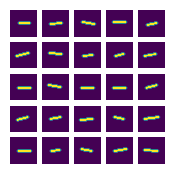

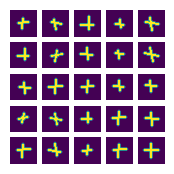

In [ ]:
from scipy.ndimage import rotate
# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):

    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [ ]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

11490434/11490434 [==============================] - 0s 0us/step
(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #8560

X_text: "42+80" = y_text: "122"


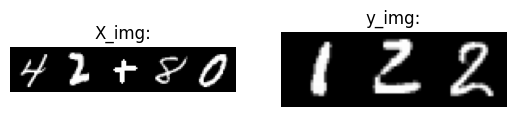

Query #887

X_text: "4-43 " = y_text: "-39"


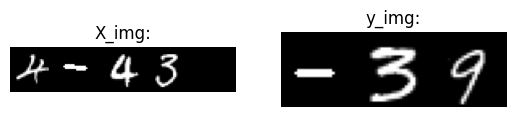

Query #1976

X_text: "9+88 " = y_text: "97 "


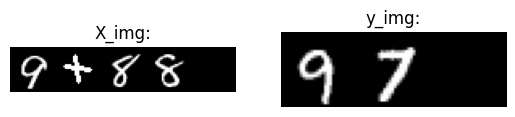

Query #5744

X_text: "28+72" = y_text: "100"


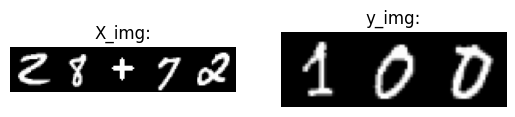

Query #1591

X_text: "7-95 " = y_text: "-88"


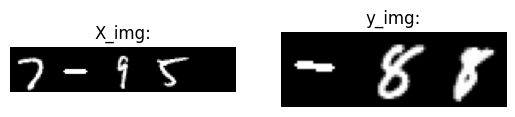

Query #4779

X_text: "23-89" = y_text: "-66"


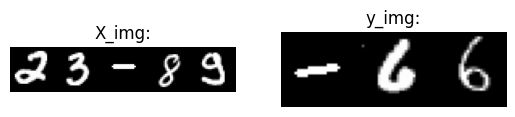

Query #5905

X_text: "29-52" = y_text: "-23"


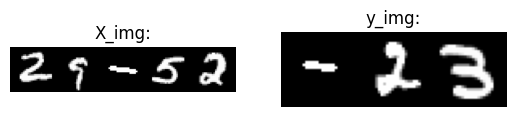

Query #7912

X_text: "39+56" = y_text: "95 "


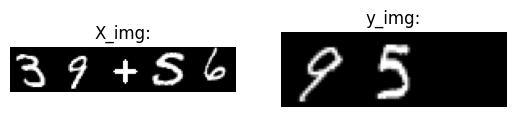

Query #666

X_text: "3+33 " = y_text: "36 "


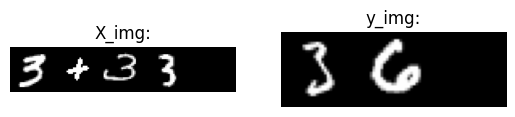

Query #3193

X_text: "15-96" = y_text: "-81"


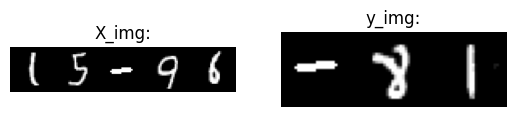

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [ ]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [ ]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

In [ ]:
# Helper functions to evaluate predictions of models with text output
import collections
import seaborn as sns
import pandas as pd

# A function to plot a histogram of distribution of amount of differences between predicted and the true labels
def plot_difference(predictions, true_labels):
  # Compute the differences
  differences = [abs(t - p) for t, p in zip(true_labels, predictions) if p is not None and p != t]

  counter= collections.Counter(differences)
  for x in sorted(counter.keys()):
    print(f"There exist {counter[x]} predictions with {x} difference")

  differences = [i for i in differences if i <= 200]

  plt.hist(differences, bins=range(1, max(differences) + 2))
  plt.xticks(np.arange(0, max(differences)+5, 5), rotation=45)
  plt.title('Distribution of Prediction Differences')
  plt.yscale('log')
  plt.xlabel('Difference between predicted and true value')
  plt.ylabel('Frequency')
  plt.show()

def plot_difference_by_char(count_incorrect_chars):
  count_incorrect_chars = [i for i in count_incorrect_chars if i != 0]
  counter= collections.Counter(count_incorrect_chars)
  y_plot = [counter[x] for x in sorted(counter.keys())]
  x_plot = sorted(counter.keys())
  plt.bar(x_plot, y_plot)
  plt.title('Distribution of Number of Digit Differences')
  plt.yscale('log')
  plt.xlabel('Number of digit difference')
  plt.ylabel('Frequency')
  plt.show()

def count_differences(str1, str2):
  return sum(c1 != c2 for c1, c2 in zip(str1, str2))

def count_incorrect_chars(predictions, true_labels):
  incorrect_counts = [count_differences(p, t) for p, t in zip(predictions, true_labels)]
  return incorrect_counts


def convert_to_int(s):
    try:
        # Remove whitespace and convert to integer
        result = int(s.replace(" ", ""))
        return result
    except ValueError:
        # For "-  " string which occurs in predictions
        return None

def misclassified_samples_analysis(predictions, true_labels, input_x):
  predicted_labels = [decode_labels(pred) for pred in predictions]
  true_labels = [decode_labels(y) for y in true_labels]
  misclassified_characters = count_incorrect_chars(predicted_labels, true_labels)
  misclassified_indices = []

  for i in range(len(true_labels)-1):
      if predicted_labels[i] != true_labels[i]:
          misclassified_indices.append(i)

  for idx in misclassified_indices[:20]:
      print(f'Misclassified Sample #{idx + 1}')
      print(f'Input {decode_labels(input_x[idx])}')
      print(f'True Label: {true_labels[idx]}')
      print(f'Predicted Label: {predicted_labels[idx]}\n')
  print('Total number of misclassified strings: ', len(misclassified_indices))
  print('Total number of misclassified characters: ', sum(misclassified_characters))

  predicted_labels = [convert_to_int(decode_labels(pred)) for pred in predictions]
  true_labels = [convert_to_int(decode_labels(y)) for y in y_text_test]

  plot_difference(predicted_labels, true_labels)
  plot_difference_by_char(misclassified_characters)

### Test size = 50%

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 256)               276480    
                                                                 
 repeat_vector_2 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 3, 256)            525312    
                                                                 
 time_distributed_2 (TimeDi  (None, 3, 13)             3341      
 stributed)                                                      
                                                                 
Total params: 805133 (3.07 MB)
Trainable params: 805133 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
1250/12

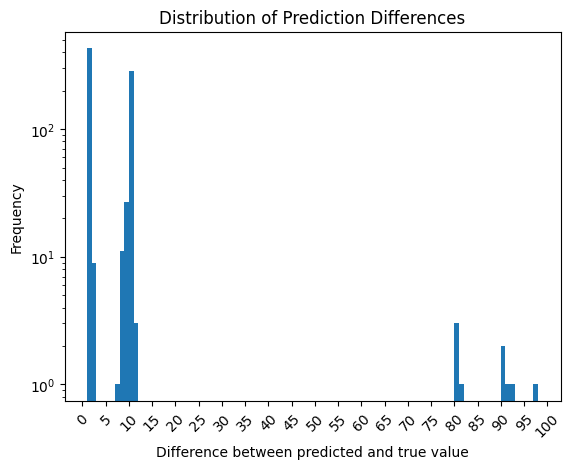

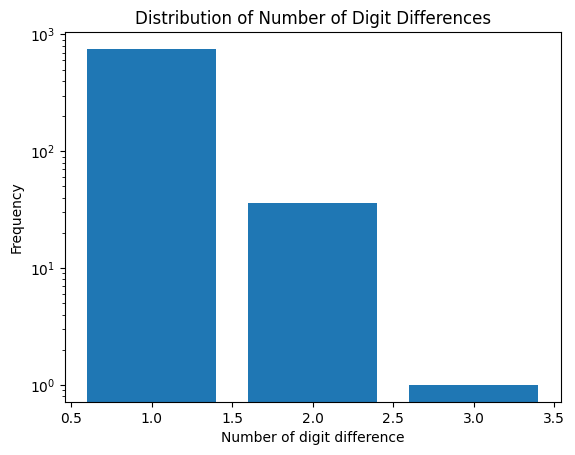

In [ ]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
    X_text_onehot, y_text_onehot, test_size=0.5, random_state=42)
model = build_text2text_model()
model.fit(X_text_train, y_text_train, epochs=20, batch_size=8, validation_data=(X_text_test, y_text_test))
loss, accuracy = model.evaluate(X_text_test, y_text_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')
model_predictions = model.predict(X_text_test)
misclassified_samples_analysis(model_predictions, y_text_test, X_text_test)

### Test size = 75%

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 256)               276480    
                                                                 
 repeat_vector_3 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                                                 
 lstm_7 (LSTM)               (None, 3, 256)            525312    
                                                                 
 time_distributed_3 (TimeDi  (None, 3, 13)             3341      
 stributed)                                                      
                                                                 
Total params: 805133 (3.07 MB)
Trainable params: 805133 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
625/625

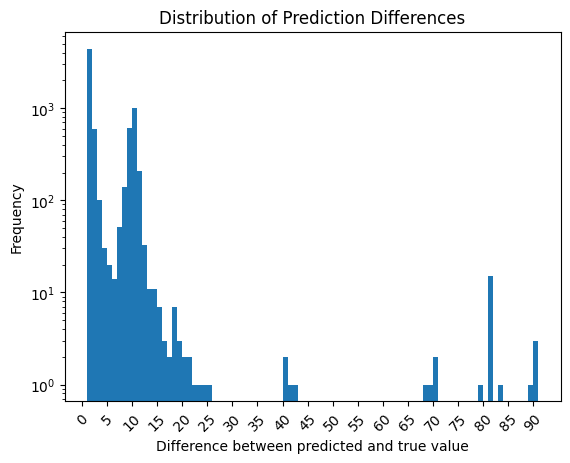

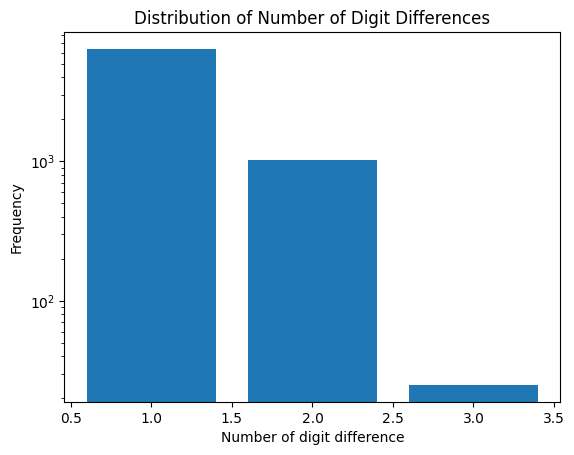

In [ ]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
    X_text_onehot, y_text_onehot, test_size=0.75, random_state=42)
model = build_text2text_model()
model.fit(X_text_train, y_text_train, epochs=20, batch_size=8, validation_data=(X_text_test, y_text_test))
loss, accuracy = model.evaluate(X_text_test, y_text_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')
model_predictions = model.predict(X_text_test)
misclassified_samples_analysis(model_predictions, y_text_test, X_text_test)

### Test size = 90%

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 256)               276480    
                                                                 
 repeat_vector_4 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                                                 
 lstm_9 (LSTM)               (None, 3, 256)            525312    
                                                                 
 time_distributed_4 (TimeDi  (None, 3, 13)             3341      
 stributed)                                                      
                                                                 
Total params: 805133 (3.07 MB)
Trainable params: 805133 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
250/250

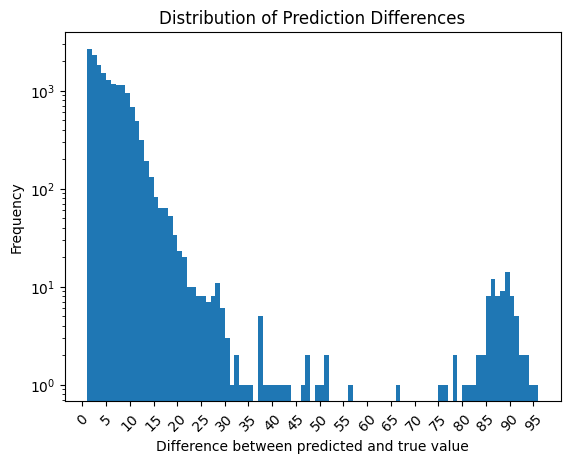

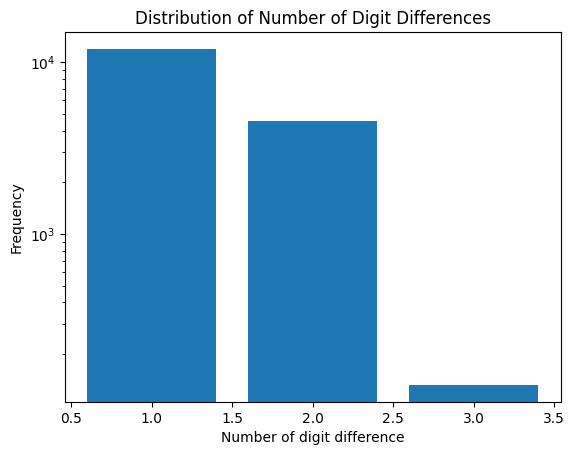

In [ ]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
    X_text_onehot, y_text_onehot, test_size=0.90, random_state=42)
model = build_text2text_model()
model.fit(X_text_train, y_text_train, epochs=20, batch_size=8, validation_data=(X_text_test, y_text_test))
loss, accuracy = model.evaluate(X_text_test, y_text_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')
model_predictions = model.predict(X_text_test)
misclassified_samples_analysis(model_predictions, y_text_test, X_text_test)

### Adding one additional LSTM layers to encoder networks - 50/50 split


In [ ]:
def build_text2text_1additional_LSTM_model():

    # We start by initializing a sequential model
    text2text_additionalLSTM = tf.keras.Sequential()

    # First LSTM layer with return_sequences=True
    text2text_additionalLSTM.add(LSTM(256, input_shape=(None, len(unique_characters)), return_sequences=True))

    # Adding additional LSTM layer(s)
    # Last LSTM layer - no need of return_sequences=True as the next layer is RepeatVector
    text2text_additionalLSTM.add(LSTM(256))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    text2text_additionalLSTM.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text_additionalLSTM.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text_additionalLSTM.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text_additionalLSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text_additionalLSTM.summary()

    return text2text_additionalLSTM

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, None, 256)         276480    
                                                                 
 lstm_19 (LSTM)              (None, 256)               525312    
                                                                 
 repeat_vector_7 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                                                 
 lstm_20 (LSTM)              (None, 3, 256)            525312    
                                                                 
 time_distributed_7 (TimeDi  (None, 3, 13)             3341      
 stributed)                                                      
                                                                 
Total params: 1330445 (5.08 MB)
Trainable params: 1330

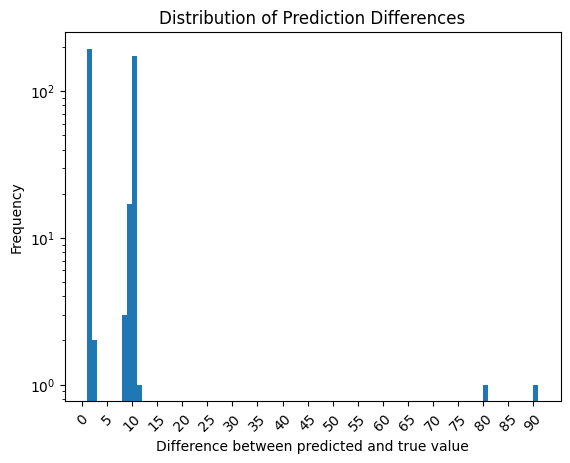

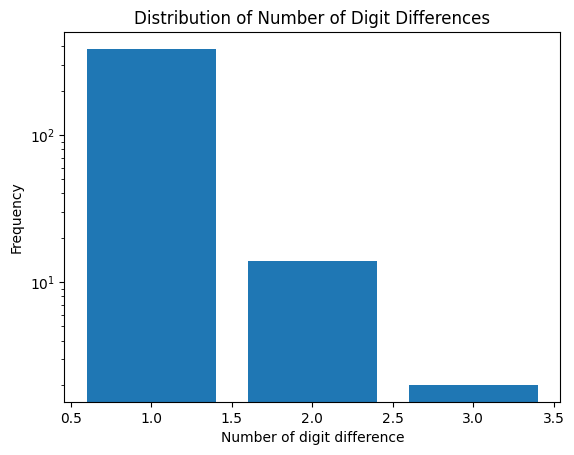

In [ ]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
    X_text_onehot, y_text_onehot, test_size=0.5, random_state=42)
model = build_text2text_1additional_LSTM_model()
model.fit(X_text_train, y_text_train, epochs=20, batch_size=8, validation_data=(X_text_test, y_text_test))
loss, accuracy = model.evaluate(X_text_test, y_text_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')
model_predictions = model.predict(X_text_test)
misclassified_samples_analysis(model_predictions, y_text_test, X_text_test)

### Adding two additional LSTM layers to encoder networks - 50/50 split


In [ ]:
def build_text2text_2additional_LSTM_model():

    # We start by initializing a sequential model
    text2text_additionalLSTM = tf.keras.Sequential()

    # First LSTM layer with return_sequences=True
    text2text_additionalLSTM.add(LSTM(256, input_shape=(None, len(unique_characters)), return_sequences=True))

    # Adding additional LSTM layer(s)
    text2text_additionalLSTM.add(LSTM(256, return_sequences=True))  # Second LSTM layer

    # Last LSTM layer - no need of return_sequences=True as the next layer is RepeatVector
    text2text_additionalLSTM.add(LSTM(256))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    text2text_additionalLSTM.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text_additionalLSTM.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text_additionalLSTM.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text_additionalLSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text_additionalLSTM.summary()

    return text2text_additionalLSTM

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, None, 256)         276480    
                                                                 
 lstm_15 (LSTM)              (None, None, 256)         525312    
                                                                 
 lstm_16 (LSTM)              (None, 256)               525312    
                                                                 
 repeat_vector_6 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                                                 
 lstm_17 (LSTM)              (None, 3, 256)            525312    
                                                                 
 time_distributed_6 (TimeDi  (None, 3, 13)             3341      
 stributed)                                           

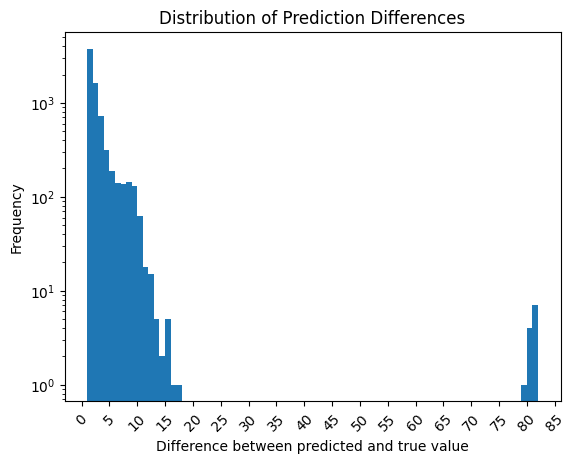

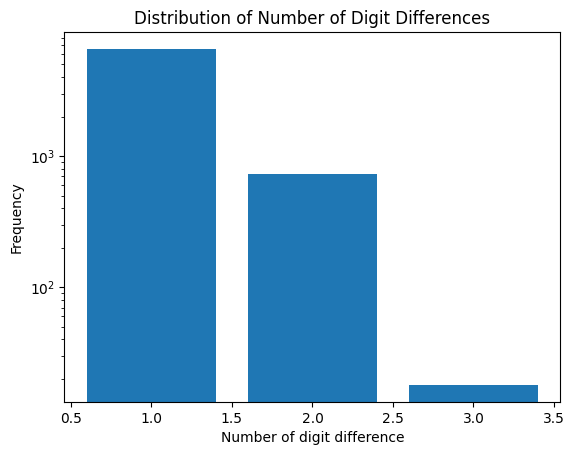

In [ ]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
    X_text_onehot, y_text_onehot, test_size=0.5, random_state=42)
model = build_text2text_2additional_LSTM_model()
model.fit(X_text_train, y_text_train, epochs=20, batch_size=8, validation_data=(X_text_test, y_text_test))
loss, accuracy = model.evaluate(X_text_test, y_text_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')
model_predictions = model.predict(X_text_test)
misclassified_samples_analysis(model_predictions, y_text_test, X_text_test)


---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [ ]:
def build_image2text_part1_model():

    image2text = tf.keras.Sequential()
    image2text.add(TimeDistributed(Conv2D(512, (3, 3), activation='relu'), input_shape=(5, 28, 28, 1)))
    image2text.add(TimeDistributed(MaxPooling2D((2, 2))))
    image2text.add(TimeDistributed(Dropout(0.25)))
    image2text.add(TimeDistributed(Flatten()))
    image2text.add(TimeDistributed(Dense(200, activation='relu')))
    image2text.add(LSTM(256))
    image2text.add(RepeatVector(max_answer_length))
    image2text.add(LSTM(256, return_sequences=True))
    image2text.add(TimeDistributed(Dense(13, activation='softmax')))
    image2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    image2text.summary()

    return image2text

In [ ]:
X_image_train, X_image_test, y_text_train, y_text_test = train_test_split(
    X_img, y_text_onehot, test_size=0.35, random_state=42)

im2txt = build_image2text_part1_model()
im2txt.fit(X_image_train, y_text_train, epochs=20, batch_size=28, validation_data=(X_image_test, y_text_test))
loss, accuracy = im2txt.evaluate(X_image_test, y_text_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDi  (None, 5, 26, 26, 512)    5120      
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 5, 13, 13, 512)    0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 5, 13, 13, 512)    0         
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 5, 86528)          0         
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, 5, 200)           

In [ ]:
predictions = im2txt.predict(X_image_test)
predicted_labels = [decode_labels(pred) for pred in predictions]
true_labels = [decode_labels(pred) for pred in y_text_test]

misclassified_indices = []
for i in range(len(X_image_test)):
    if predicted_labels[i] != true_labels[i]:
      misclassified_indices.append(i)

for idx in misclassified_indices:
    print(f'Misclassified Sample #{idx + 1}')
    print(f'True Label: {decode_labels(y_text_test[idx])}')
    print(f'Predicted Label: {predicted_labels[idx]}\n')

219/219 [==============================] - 2s 7ms/step
Misclassified Sample #12
True Label: 0  
Predicted Label: -  

Misclassified Sample #14
True Label: 129
Predicted Label: 130

Misclassified Sample #17
True Label: 0  
Predicted Label: 10 

Misclassified Sample #33
True Label: 46 
Predicted Label: 47 

Misclassified Sample #40
True Label: 84 
Predicted Label: 83 

Misclassified Sample #41
True Label: 97 
Predicted Label: 87 

Misclassified Sample #49
True Label: -12
Predicted Label: -32

Misclassified Sample #57
True Label: 81 
Predicted Label: 74 

Misclassified Sample #70
True Label: 139
Predicted Label: 144

Misclassified Sample #72
True Label: -2 
Predicted Label: -1 

Misclassified Sample #74
True Label: 124
Predicted Label: 123

Misclassified Sample #79
True Label: -78
Predicted Label: -68

Misclassified Sample #94
True Label: 79 
Predicted Label: 89 

Misclassified Sample #104
True Label: 49 
Predicted Label: 50 

Misclassified Sample #112
True Label: 24 
Predicted Label: 74 

Adding one LSTM layer to our model


In [ ]:
def build_image2text_part1_1LSTM_model():

    image2text = tf.keras.Sequential()
    image2text.add(TimeDistributed(Conv2D(512, (3, 3), activation='relu'), input_shape=(5, 28, 28, 1)))
    image2text.add(TimeDistributed(MaxPooling2D((2, 2))))
    image2text.add(TimeDistributed(Dropout(0.25)))
    image2text.add(TimeDistributed(Flatten()))
    image2text.add(TimeDistributed(Dense(200, activation='relu')))
    image2text.add(LSTM(256, return_sequences=True))
    image2text.add(LSTM(256))
    image2text.add(RepeatVector(max_answer_length))
    image2text.add(LSTM(256, return_sequences=True))
    image2text.add(TimeDistributed(Dense(13, activation='softmax')))
    image2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    image2text.summary()

    return image2text

In [ ]:
## Your code (look at the assignment description for your tasks for image-to-text model):

X_image_train, X_image_test, y_text_train, y_text_test = train_test_split(
    X_img, y_text_onehot, test_size=0.35, random_state=42)

im2txt = build_image2text_part1_1LSTM_model()
im2txt.fit(X_image_train, y_text_train, epochs=20, batch_size=28, validation_data=(X_image_test, y_text_test))
loss, accuracy = im2txt.evaluate(X_image_test, y_text_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

predictions = im2txt.predict(X_image_test)
predicted_labels = [decode_labels(pred) for pred in predictions]
true_labels = [decode_labels(pred) for pred in y_text_test]

misclassified_indices = []
for i in range(len(X_image_test)):
    if predicted_labels[i] != true_labels[i]:
      misclassified_indices.append(i)

for idx in misclassified_indices:
    print(f'Misclassified Sample #{idx + 1}')
    print(f'True Label: {decode_labels(y_text_test[idx])}')
    print(f'Predicted Label: {predicted_labels[idx]}\n')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDi  (None, 5, 26, 26, 512)    5120      
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, 5, 13, 13, 512)    0         
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, 5, 13, 13, 512)    0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 5, 86528)          0         
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None, 5, 200)           

Adding two LSTM layers to our model


In [ ]:
def build_image2text_part1_2LSTM_model():

    image2text = tf.keras.Sequential()
    image2text.add(TimeDistributed(Conv2D(512, (3, 3), activation='relu'), input_shape=(5, 28, 28, 1)))
    image2text.add(TimeDistributed(MaxPooling2D((2, 2))))
    image2text.add(TimeDistributed(Dropout(0.25)))
    image2text.add(TimeDistributed(Flatten()))
    image2text.add(TimeDistributed(Dense(200, activation='relu')))
    image2text.add(LSTM(256, return_sequences=True))
    image2text.add(LSTM(256, return_sequences=True))
    image2text.add(LSTM(256))
    image2text.add(RepeatVector(max_answer_length))
    image2text.add(LSTM(256, return_sequences=True))
    image2text.add(TimeDistributed(Dense(13, activation='softmax')))
    image2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    image2text.summary()

    return image2text

## Your code (look at the assignment description for your tasks for image-to-text model):

X_image_train, X_image_test, y_text_train, y_text_test = train_test_split(
    X_img, y_text_onehot, test_size=0.35, random_state=42)

im2txt = build_image2text_part1_2LSTM_model()
im2txt.fit(X_image_train, y_text_train, epochs=20, batch_size=28, validation_data=(X_image_test, y_text_test))
loss, accuracy = im2txt.evaluate(X_image_test, y_text_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

predictions = im2txt.predict(X_image_test)
predicted_labels = [decode_labels(pred) for pred in predictions]
true_labels = [decode_labels(pred) for pred in y_text_test]

misclassified_indices = []
for i in range(len(X_image_test)):
    if predicted_labels[i] != true_labels[i]:
      misclassified_indices.append(i)

for idx in misclassified_indices:
    print(f'Misclassified Sample #{idx + 1}')
    print(f'True Label: {decode_labels(y_text_test[idx])}')
    print(f'Predicted Label: {predicted_labels[idx]}\n')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeD  (None, 5, 26, 26, 512)    5120      
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, 5, 13, 13, 512)    0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, 5, 13, 13, 512)    0         
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, 5, 86528)          0         
 istributed)                                                     
                                                                 
 time_distributed_18 (TimeD  (None, 5, 200)           

---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [ ]:
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout, Reshape, Conv2DTranspose, BatchNormalization

def build_text2image_model():
    text2img = tf.keras.Sequential()

    # Encoder remains the same
    text2img.add(LSTM(512, input_shape=(None, len(unique_characters)), return_sequences=False)) # Only the final output of the sequence is used
    text2img.add(Dropout(0.2)) # Dropout to prevent overfitting
    text2img.add(RepeatVector(3)) # To match the desired output sequence length

    # Decoder with LSTM
    text2img.add(LSTM(256, return_sequences=True))
    text2img.add(TimeDistributed(Dense(7 * 7 * 128, activation='relu'))) # Apply dense layer with relu to transform the output
    text2img.add(Dropout(0.2))

    # Reshape output for subsequent convolutional layers
    text2img.add(Reshape((3, 7, 7, 128)))

    # Decoder with Conv2DTranspose layers
    # Final layer outputs a grayscale image (1 channel) with pixel values in the range [0, 1]
    text2img.add(BatchNormalization())
    text2img.add(TimeDistributed(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')))
    text2img.add(BatchNormalization())
    text2img.add(TimeDistributed(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid')))

    text2img.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    text2img.summary()

    return text2img

In [ ]:
model = build_text2image_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1077248   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 3, 512)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 3, 256)            787456    
                                                                 
 time_distributed (TimeDist  (None, 3, 6272)           1611904   
 ributed)                                                        
                                                                 
 dropout_1 (Dropout)         (None, 3, 6272)           0

In [ ]:
# y_img = np.transpose(y_img, (0, 2, 3, 1))
X_text_train, X_text_test, y_image_train, y_image_test = train_test_split(X_text_onehot, y_img, test_size=0.2, random_state=42)
model.fit(X_text_train, y_image_train, epochs=20, batch_size=8, validation_data=(X_text_test, y_image_test))
loss, accuracy = model.evaluate(X_text_test, y_image_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/20
2000/2000 [==============================] - 34s 8ms/step - loss: 0.0554 - accuracy: 0.8585 - val_loss: 0.0479 - val_accuracy: 0.8640
Epoch 2/20
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0477 - accuracy: 0.8635 - val_loss: 0.0468 - val_accuracy: 0.8642
Epoch 3/20
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0471 - accuracy: 0.8630 - val_loss: 0.0461 - val_accuracy: 0.8648
Epoch 4/20
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0466 - accuracy: 0.8626 - val_loss: 0.0461 - val_accuracy: 0.8619
Epoch 5/20
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0462 - accuracy: 0.8624 - val_loss: 0.0460 - val_accuracy: 0.8663
Epoch 6/20
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0460 - accuracy: 0.8621 - val_loss: 0.0455 - val_accuracy: 0.8623
Epoch 7/20
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0456 - accuracy: 0.8619 - val_loss: 0.0449 - val_ac

1/1 [==============================] - 0s 30ms/step


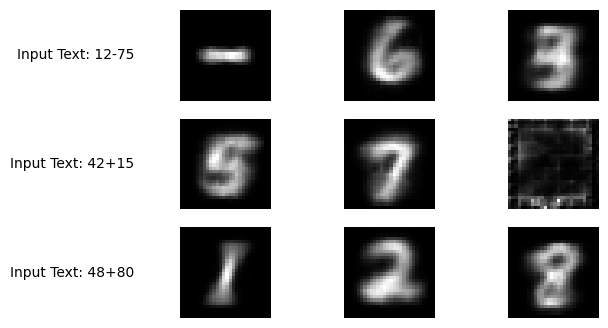

In [ ]:
# Function to make predictions
def predict_model(model, text):
    text_onehot = encode_labels([text], max_len=5)
    final_image = model.predict(text_onehot).reshape((3, 28, 28))
    return final_image

input_text_1, input_text_2, input_text_3 = '12-75', '42+15', '48+80'
output_image_1, output_image_2, output_image_3 = predict_model(model, input_text_1), predict_model(model, input_text_2), predict_model(model, input_text_3)

# Function to show sample images based on the predictions
def display_images(*images, labels=None):
    fig, axs = plt.subplots(len(images), 3, figsize=(6, 4))
    for i, image in enumerate(images):
        for j in range(3):
            axs[i, j].imshow(image[j], cmap='gray')
            axs[i, j].axis('off')

        if labels:
            axs[i, 0].text(-0.5, 0.5, labels[i], verticalalignment='center', horizontalalignment='right', fontsize=10, transform=axs[i, 0].transAxes)

    plt.show()

display_images(output_image_1, output_image_2, output_image_3, labels=['Input Text: 12-75', 'Input Text: 42+15', 'Input Text: 48+80'])

### Adding one additional LSTM layer to encoder networks

In [ ]:
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout, Reshape, Conv2DTranspose, BatchNormalization

def build_text2image_model_with_additional_lstm():
    text2img = tf.keras.Sequential()

    # Additional LSTM layer in the encoder
    text2img.add(LSTM(512, input_shape=(None, len(unique_characters)), return_sequences=True))  # Return sequences for the subsequent LSTM layer
    text2img.add(LSTM(512, return_sequences=False))  # Only the final output of the sequence is used
    text2img.add(Dropout(0.2))  # Dropout to prevent overfitting
    text2img.add(RepeatVector(3))  # To match the desired output sequence length

    # Decoder with LSTM
    text2img.add(LSTM(256, return_sequences=True))
    text2img.add(TimeDistributed(Dense(7 * 7 * 128, activation='relu')))
    text2img.add(Dropout(0.2))

    # Reshape output for subsequent convolutional layers
    text2img.add(Reshape((3, 7, 7, 128)))

    # Decoder with Conv2DTranspose layers
    text2img.add(BatchNormalization())
    text2img.add(TimeDistributed(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')))
    text2img.add(BatchNormalization())
    text2img.add(TimeDistributed(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid')))

    text2img.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    text2img.summary()

    return text2img

In [ ]:
model_2 = build_text2image_model_with_additional_lstm()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, None, 512)         1077248   
                                                                 
 lstm_10 (LSTM)              (None, 512)               2099200   
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 repeat_vector_3 (RepeatVec  (None, 3, 512)            0         
 tor)                                                            
                                                                 
 lstm_11 (LSTM)              (None, 3, 256)            787456    
                                                                 
 time_distributed_9 (TimeDi  (None, 3, 6272)           1611904   
 stributed)                                           

In [ ]:
# y_img = np.transpose(y_img, (0, 2, 3, 1))
X_text_train, X_text_test, y_image_train, y_image_test = train_test_split(X_text_onehot, y_img, test_size=0.2, random_state=42)
model_2.fit(X_text_train, y_image_train, epochs=20, batch_size=8, validation_data=(X_text_test, y_image_test))
loss, accuracy = model_2.evaluate(X_text_test, y_image_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/20
2000/2000 [==============================] - 26s 10ms/step - loss: 0.0566 - accuracy: 0.8573 - val_loss: 0.0481 - val_accuracy: 0.8648
Epoch 2/20
2000/2000 [==============================] - 19s 10ms/step - loss: 0.0477 - accuracy: 0.8630 - val_loss: 0.0464 - val_accuracy: 0.8648
Epoch 3/20
2000/2000 [==============================] - 18s 9ms/step - loss: 0.0470 - accuracy: 0.8625 - val_loss: 0.0463 - val_accuracy: 0.8636
Epoch 4/20
2000/2000 [==============================] - 19s 9ms/step - loss: 0.0466 - accuracy: 0.8622 - val_loss: 0.0459 - val_accuracy: 0.8629
Epoch 5/20
2000/2000 [==============================] - 20s 10ms/step - loss: 0.0461 - accuracy: 0.8617 - val_loss: 0.0454 - val_accuracy: 0.8646
Epoch 6/20
2000/2000 [==============================] - 18s 9ms/step - loss: 0.0458 - accuracy: 0.8614 - val_loss: 0.0452 - val_accuracy: 0.8643
Epoch 7/20
2000/2000 [==============================] - 18s 9ms/step - loss: 0.0454 - accuracy: 0.8612 - val_loss: 0.0451 - val

1/1 [==============================] - 0s 18ms/step


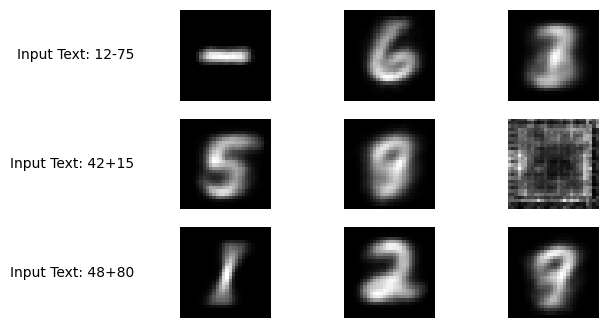

In [ ]:
def predict_model(model, text):
    text_onehot = encode_labels([text], max_len=5)
    final_image = model.predict(text_onehot).reshape((3, 28, 28))
    return final_image

input_text_1, input_text_2, input_text_3 = '12-75', '42+15', '48+80'
output_image_1, output_image_2, output_image_3 = predict_model(model_2, input_text_1), predict_model(model_2, input_text_2), predict_model(model_2, input_text_3)

def display_images(*images, labels=None):
    fig, axs = plt.subplots(len(images), 3, figsize=(6, 4))
    for i, image in enumerate(images):
        for j in range(3):
            axs[i, j].imshow(image[j], cmap='gray')
            axs[i, j].axis('off')

        if labels:
            axs[i, 0].text(-0.5, 0.5, labels[i], verticalalignment='center', horizontalalignment='right', fontsize=10, transform=axs[i, 0].transAxes)

    plt.show()

display_images(output_image_1, output_image_2, output_image_3, labels=['Input Text: 12-75', 'Input Text: 42+15', 'Input Text: 48+80'])

### Adding two additional LSTM layers to encoder networks

In [ ]:
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout, Reshape, Conv2DTranspose, BatchNormalization

def build_text2image_model_with_two_additional_lstm_2():
    text2img = tf.keras.Sequential()

    # Additional LSTM layer in the encoder
    text2img.add(LSTM(512, input_shape=(None, len(unique_characters)), return_sequences=True))  # Return sequences for the subsequent LSTM layer
    text2img.add(LSTM(256, return_sequences=True))
    text2img.add(LSTM(128, return_sequences=False))  # Only the final output of the sequence is used
    text2img.add(Dropout(0.2))  # Dropout to prevent overfitting
    text2img.add(RepeatVector(3))  # To match the desired output sequence length

    # Decoder with LSTM
    text2img.add(LSTM(256, return_sequences=True))
    text2img.add(TimeDistributed(Dense(7 * 7 * 128, activation='relu')))
    text2img.add(Dropout(0.2))

    # Reshape output for subsequent convolutional layers
    text2img.add(Reshape((3, 7, 7, 128)))

    # Decoder with Conv2DTranspose layers
    text2img.add(BatchNormalization())
    text2img.add(TimeDistributed(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')))
    text2img.add(BatchNormalization())
    text2img.add(TimeDistributed(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid')))

    text2img.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    text2img.summary()

    return text2img

In [ ]:
model_4 = build_text2image_model_with_two_additional_lstm_2()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, None, 512)         1077248   
                                                                 
 lstm_5 (LSTM)               (None, None, 256)         787456    
                                                                 
 lstm_6 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_1 (RepeatVec  (None, 3, 128)            0         
 tor)                                                            
                                                                 
 lstm_7 (LSTM)               (None, 3, 256)            394240    
                                                      

In [ ]:
# y_img = np.transpose(y_img, (0, 2, 3, 1))
X_text_train, X_text_test, y_image_train, y_image_test = train_test_split(X_text_onehot, y_img, test_size=0.2, random_state=42)
model_4.fit(X_text_train, y_image_train, epochs=20, batch_size=8, validation_data=(X_text_test, y_image_test))
loss, accuracy = model_4.evaluate(X_text_test, y_image_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/20
2000/2000 [==============================] - 36s 14ms/step - loss: 0.0563 - accuracy: 0.8579 - val_loss: 0.0478 - val_accuracy: 0.8667
Epoch 2/20
2000/2000 [==============================] - 24s 12ms/step - loss: 0.0476 - accuracy: 0.8634 - val_loss: 0.0467 - val_accuracy: 0.8651
Epoch 3/20
2000/2000 [==============================] - 26s 13ms/step - loss: 0.0469 - accuracy: 0.8627 - val_loss: 0.0460 - val_accuracy: 0.8633
Epoch 4/20
2000/2000 [==============================] - 27s 13ms/step - loss: 0.0464 - accuracy: 0.8623 - val_loss: 0.0462 - val_accuracy: 0.8616
Epoch 5/20
2000/2000 [==============================] - 25s 13ms/step - loss: 0.0460 - accuracy: 0.8619 - val_loss: 0.0454 - val_accuracy: 0.8618
Epoch 6/20
2000/2000 [==============================] - 25s 13ms/step - loss: 0.0457 - accuracy: 0.8616 - val_loss: 0.0456 - val_accuracy: 0.8622
Epoch 7/20
2000/2000 [==============================] - 27s 14ms/step - loss: 0.0454 - accuracy: 0.8614 - val_loss: 0.0450 -

1/1 [==============================] - 0s 44ms/step


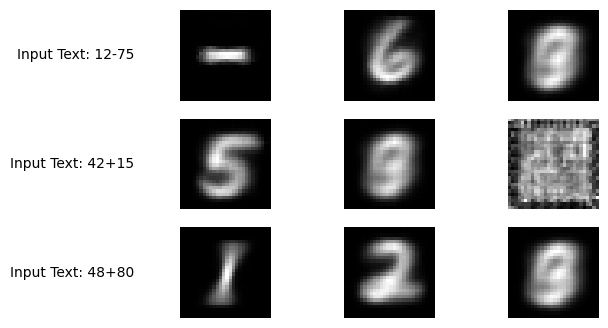

In [ ]:
def predict_model(model, text):
    text_onehot = encode_labels([text], max_len=5)
    final_image = model.predict(text_onehot).reshape((3, 28, 28))
    return final_image

input_text_1, input_text_2, input_text_3 = '12-75', '42+15', '48+80'
output_image_1, output_image_2, output_image_3 = predict_model(model_4, input_text_1), predict_model(model_4, input_text_2), predict_model(model_4, input_text_3)

def display_images(*images, labels=None):
    fig, axs = plt.subplots(len(images), 3, figsize=(6, 4))
    for i, image in enumerate(images):
        for j in range(3):
            axs[i, j].imshow(image[j], cmap='gray')
            axs[i, j].axis('off')

        if labels:
            axs[i, 0].text(-0.5, 0.5, labels[i], verticalalignment='center', horizontalalignment='right', fontsize=10, transform=axs[i, 0].transAxes)

    plt.show()

display_images(output_image_1, output_image_2, output_image_3, labels=['Input Text: 12-75', 'Input Text: 42+15', 'Input Text: 48+80'])


---
---
---

# Part 2: Multiplication
The cell below will create the multiplication dataset used in this part of the assignment.

(10000,) (10000, 5, 28, 28) (10000,) (10000, 5, 28, 28)
Query #1670

X_text: "16*70" = y_text: "1120 "


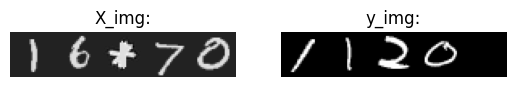

Query #3461

X_text: "34*61" = y_text: "2074 "


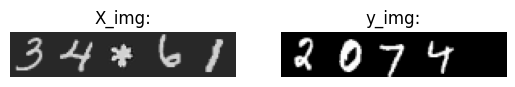

Query #7364

X_text: "73*64" = y_text: "4672 "


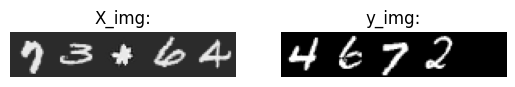

Query #916

X_text: "9*16 " = y_text: "144  "


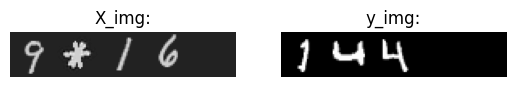

Query #6646

X_text: "66*46" = y_text: "3036 "


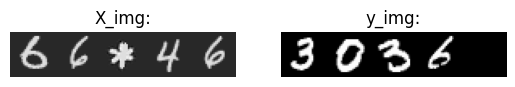

Query #5458

X_text: "54*58" = y_text: "3132 "


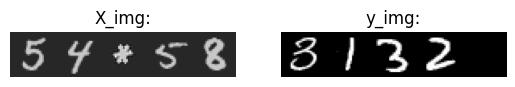

Query #3449

X_text: "34*49" = y_text: "1666 "


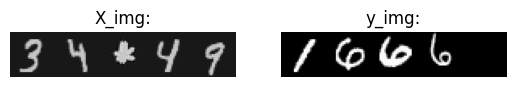

Query #9586

X_text: "95*86" = y_text: "8170 "


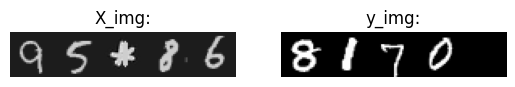

Query #6771

X_text: "67*71" = y_text: "4757 "


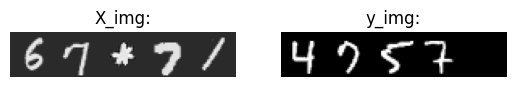

Query #5354

X_text: "53*54" = y_text: "2862 "


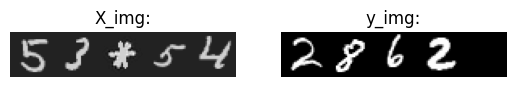

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789* '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 5    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer, operands=['*'])
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Text-to-Text model

In [ ]:
def build_text2text_model_mult():

    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    unique_characters = '0123456789* '
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 5 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    max_answer_length = 5
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

In [ ]:
# Experimenting with different splits
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
    X_text_onehot, y_text_onehot, test_size=0.5, random_state=42)

model_mult = build_text2text_model_mult()
model_mult.fit(X_text_train, y_text_train, epochs=20, batch_size=8, validation_data=(X_text_test, y_text_test))
loss, accuracy = model_mult.evaluate(X_text_test, y_text_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 256)               275456    
                                                                 
 repeat_vector_14 (RepeatVe  (None, 5, 256)            0         
 ctor)                                                           
                                                                 
 lstm_35 (LSTM)              (None, 5, 256)            525312    
                                                                 
 time_distributed_14 (TimeD  (None, 5, 12)             3084      
 istributed)                                                     
                                                                 
Total params: 803852 (3.07 MB)
Trainable params: 803852 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
625/62

### Adding one additional LSTM layer

In [ ]:
def build_text2text_1additional_LSTM_model_mult():

    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    unique_characters = '0123456789* '
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters)), return_sequences=True))
    text2text.add(LSTM(256))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 5 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    max_answer_length = 5
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

In [ ]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
    X_text_onehot, y_text_onehot, test_size=0.5, random_state=42)

model_mult = build_text2text_1additional_LSTM_model_mult()
model_mult.fit(X_text_train, y_text_train, epochs=20, batch_size=8, validation_data=(X_text_test, y_text_test))
loss, accuracy = model_mult.evaluate(X_text_test, y_text_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, None, 256)         275456    
                                                                 
 lstm_41 (LSTM)              (None, 256)               525312    
                                                                 
 repeat_vector_17 (RepeatVe  (None, 5, 256)            0         
 ctor)                                                           
                                                                 
 lstm_42 (LSTM)              (None, 5, 256)            525312    
                                                                 
 time_distributed_17 (TimeD  (None, 5, 12)             3084      
 istributed)                                                     
                                                                 
Total params: 1329164 (5.07 MB)
Trainable params: 132

### Changing LSTM Input size

In [ ]:
def build_text2text_model_mult():

    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    unique_characters = '0123456789* '
    text2text.add(LSTM(512, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 5 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    max_answer_length = 5
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    text2text.add(LSTM(512, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
    X_text_onehot, y_text_onehot, test_size=0.4, random_state=42)

model_mult = build_text2text_model_mult()
model_mult.fit(X_text_train, y_text_train, epochs=20, batch_size=8, validation_data=(X_text_test, y_text_test))
loss, accuracy = model_mult.evaluate(X_text_test, y_text_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 512)               1075200   
                                                                 
 repeat_vector_19 (RepeatVe  (None, 5, 512)            0         
 ctor)                                                           
                                                                 
 lstm_46 (LSTM)              (None, 5, 512)            2099200   
                                                                 
 time_distributed_19 (TimeD  (None, 5, 12)             6156      
 istributed)                                                     
                                                                 
Total params: 3180556 (12.13 MB)
Trainable params: 3180556 (12.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
75

# Image-to-text model


In [ ]:
def build_image2text_part2_model():
    image2text = tf.keras.Sequential()
    image2text.add(TimeDistributed(Conv2D(64, (5, 5), activation='relu'), input_shape=(5, 28, 28, 1)))
    image2text.add(TimeDistributed(MaxPooling2D((2, 2))))
    image2text.add(TimeDistributed(Dropout(0.25)))
    image2text.add(TimeDistributed(Conv2D(512, (5, 5), activation='relu')))
    image2text.add(TimeDistributed(MaxPooling2D((2, 2))))
    image2text.add(TimeDistributed(Dropout(0.25)))
    image2text.add(TimeDistributed(Conv2D(512, (3, 3), activation='relu')))
    image2text.add(TimeDistributed(MaxPooling2D((2, 2))))
    image2text.add(TimeDistributed(Dropout(0.3)))
    image2text.add(TimeDistributed(Flatten()))
    image2text.add(TimeDistributed(Dense(200, activation='relu')))
    image2text.add(LSTM(512))
    image2text.add(RepeatVector(max_answer_length))
    image2text.add(LSTM(128, return_sequences=True))
    image2text.add(TimeDistributed(Dense(12, activation='softmax')))
    image2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    image2text.summary()

    return image2text

In [ ]:
y_text_onehot = encode_labels(y_text)
X_image_train, X_image_test, y_text_train, y_text_test = train_test_split(
    X_img, y_text_onehot, test_size=0.35, random_state=42)

img2txt = build_image2text_part2_model()
img2txt.fit(X_image_train, y_text_train, epochs=20, batch_size=28, validation_data=(X_image_test, y_text_test))
loss, accuracy = img2txt.evaluate(X_image_test, y_text_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_44 (TimeD  (None, 5, 24, 24, 64)     1664      
 istributed)                                                     
                                                                 
 time_distributed_45 (TimeD  (None, 5, 12, 12, 64)     0         
 istributed)                                                     
                                                                 
 time_distributed_46 (TimeD  (None, 5, 12, 12, 64)     0         
 istributed)                                                     
                                                                 
 time_distributed_47 (TimeD  (None, 5, 8, 8, 512)      819712    
 istributed)                                                     
                                                                 
 time_distributed_48 (TimeD  (None, 5, 4, 4, 512)     

In [ ]:
predictions = img2txt.predict(X_image_test)
predicted_labels = [decode_labels(pred) for pred in predictions]
true_labels = [decode_labels(pred) for pred in y_text_test]

misclassified_indices = []

for i in range(len(X_image_test)):
    if predicted_labels[i] != true_labels[i]:
        misclassified_indices.append(i)

for idx in misclassified_indices:
    print(f'Misclassified Sample #{idx + 1}')
    print(f'True Label: {true_labels[idx]}')
    print(f'Predicted Label: {predicted_labels[idx]}\n')